In [ ]:
# import library yang dibutuhkan

from google.colab import files # untuk pengaturan files pada google colabs

import matplotlib.pyplot as plt # untuk visualisasi

# framework machine learning
import tensorflow as tf
import tensorflow_datasets as tfds # tensorflow dataset
from tensorflow.keras.backend import clear_session
# code disini -> import models, layers, dan optimizers dari tensorflow keras
import numpy as np
import os
import PIL

import zipfile
import glob
import warnings


# Library u/ machine learning Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Library u/  upload file gcolabs dan plot
from keras.preprocessing import image
import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.utils.vis_utils import plot_model # untuk output model berupa image

import warnings
warnings.filterwarnings('ignore')

## Data Loading

Dataset: https://www.tensorflow.org/datasets/catalog/malaria

In [ ]:
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteXFV2S4/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# function untuk split data (pemisahan data)

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  non_train_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  val_dataset = non_train_dataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = non_train_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset

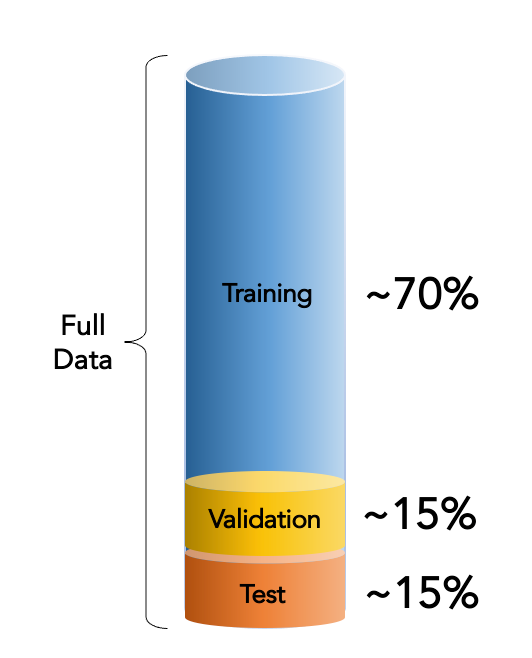

In [ ]:
# ratio spilt data

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO ) # code disini

In [ ]:
print("Total dataset\t\t: {}".format(len(dataset[0])))
print("Total Training Dataset\t: {}".format(len(train_dataset)))
print("Total Validation Dataset: {}".format(len(val_dataset)))
print("Total Testing Dataset\t: {}".format(len(test_dataset)))

Total dataset		: 27558
Total Training Dataset	: 19290
Total Validation Dataset: 4133
Total Testing Dataset	: 4135


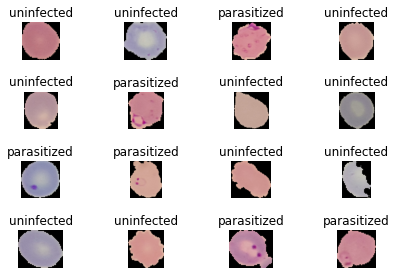

In [ ]:
# visualisasi dataset

fig, ax = plt.subplots(4,4)
fig.tight_layout()

for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.imshow(image) # code disini
  plt.axis('off')

Sebelum melakukan tahap modelling, kita harus mempersiapkan dataset. Berikut pipeline dataset.
1. Resize gambar jadi ukuran tertentu (height, width)
2. Normalisasi piksel dari 0-255 jadi 0-1
3. Tentukan batch size (jumlah image yang digunakan dalam satu iterasi)

In [ ]:
# rescale: normalisasi pixel gambar

IM_SIZE = 224 # code disini -> ukuran panjang dan lebar gambar (224)

def resize_rescale(image,label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

In [ ]:
BATCH_SIZE = 32 # image dalam satu iterasi
SHUFFLE_BUFFER = 128 # keacakan transformasi

train_dataset = train_dataset.map(resize_rescale).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Sebelum menggunakan pipeline:

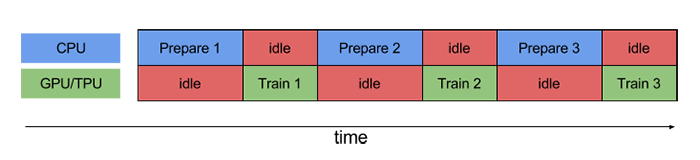

Sesudah menggunakan pipeline:

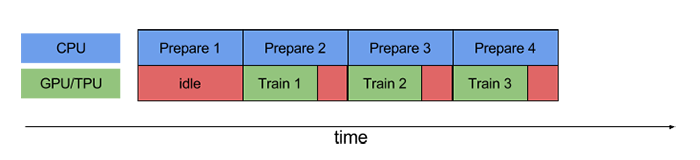

## Modelling

In [ ]:
# code yang diedit disini
# model

# code yang diedit disini
# model

clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IM_SIZE, IM_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.9))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# code disini -> untuk membuat model image classification

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                    

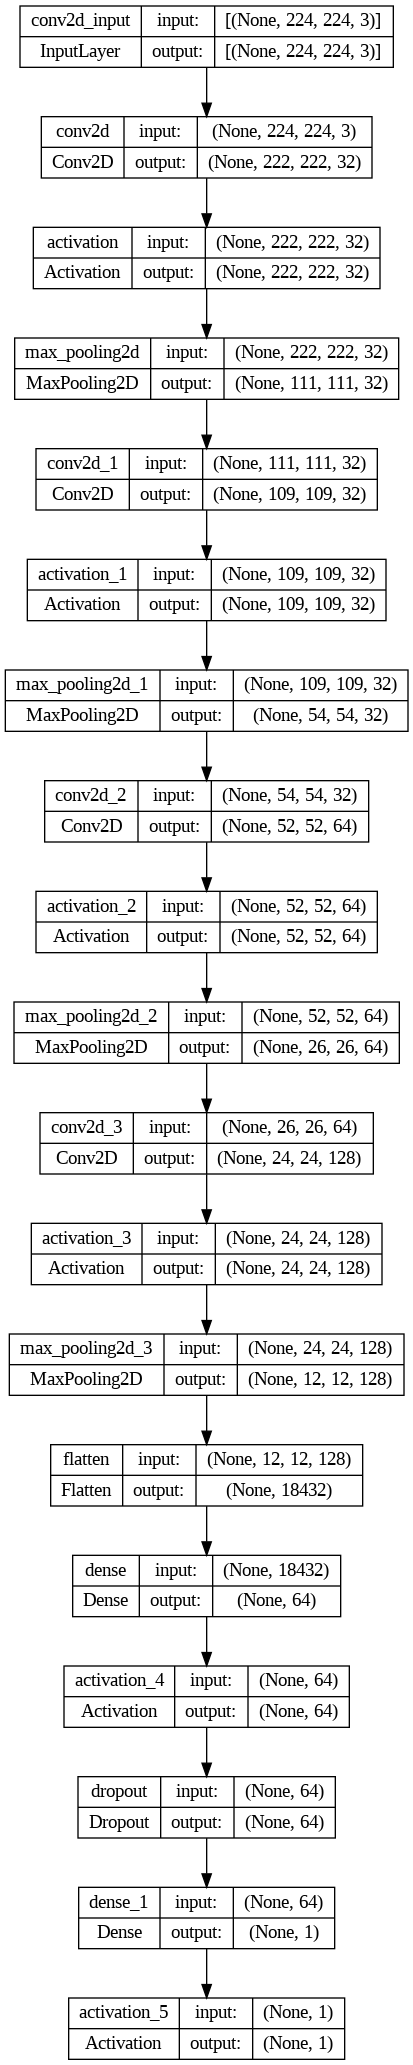

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) #save image model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(  train_dataset,
  validation_data=val_dataset,
  epochs=15 #code disini
            )

Epoch 1/15
603/603 [==============================] - 47s 72ms/step - loss: 0.6981 - accuracy: 0.5162 - val_loss: 0.6531 - val_accuracy: 0.6990
Epoch 2/15
603/603 [==============================] - 44s 72ms/step - loss: 0.6831 - accuracy: 0.5369 - val_loss: 0.6784 - val_accuracy: 0.5688
Epoch 3/15
603/603 [==============================] - 45s 73ms/step - loss: 0.6548 - accuracy: 0.5944 - val_loss: 0.3655 - val_accuracy: 0.8848
Epoch 4/15
603/603 [==============================] - 43s 71ms/step - loss: 0.3256 - accuracy: 0.8889 - val_loss: 0.1923 - val_accuracy: 0.9480
Epoch 5/15
603/603 [==============================] - 43s 71ms/step - loss: 0.2483 - accuracy: 0.9293 - val_loss: 0.1729 - val_accuracy: 0.9519
Epoch 6/15
603/603 [==============================] - 43s 72ms/step - loss: 0.2151 - accuracy: 0.9359 - val_loss: 0.1649 - val_accuracy: 0.9562
Epoch 7/15
603/603 [==============================] - 45s 74ms/step - loss: 0.2013 - accuracy: 0.9411 - val_loss: 0.1493 - val_accuracy:

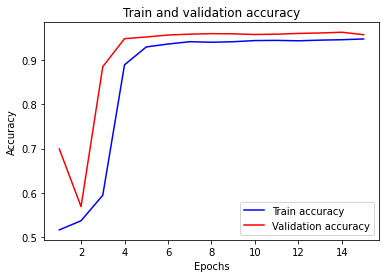

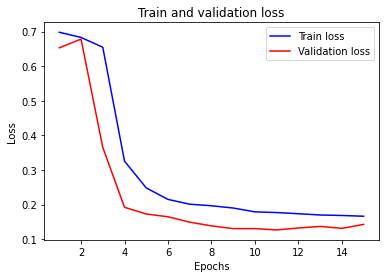

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# code disini -> visualisasi akurasi dan loss
epochs = range(1, len(train_acc) + 1)

# plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Train accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

# plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



plt.show()

In [ ]:
# save model
model.save('malaria.h5')

In [ ]:
# evaluasi model
model # code disini -> evaluasi dari test data

In [ ]:
# download file
files.download('malaria.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test Model

In [ ]:
## TESTING - DONT EDIT

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model

import argparse

IM_SIZE = 224
BATCH_SIZE = 16

def resize_rescale(image,label):
    return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0,label

def preprocessing(dataset):
    return dataset[0].map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def get_acc(model):
    dataset, _ = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])
    preprocessing_image = preprocessing(dataset)

    model = load_model(model)
    acc = model.evaluate(preprocessing_image)[1]*100
    return print("model accuracy: {:.3f} %".format(acc))

In [ ]:
model = "/content/malaria.h5"
get_acc(model)

1723/1723 [==============================] - 33s 19ms/step - loss: 0.1297 - accuracy: 0.9599
model accuracy: 95.994 %


1/1 [==============================] - 0s 102ms/step


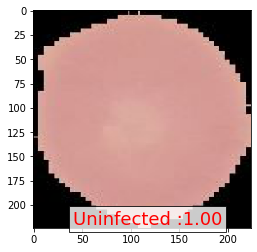

In [ ]:
IM_SIZE = 224
img = tf.keras.utils.load_img('uni.jpeg', target_size=(IM_SIZE, IM_SIZE))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array,batch_size=None,steps=1)
score = tf.nn.sigmoid(predictions[0])

#print("This image most likely belongs to {} with a {:.2f}% confidence.".format(ds_names[np.argmax(score)], 100 * np.max(score)))
if predictions[0] > 0.5:
  value ='Uninfected :%1.2f'%(predictions[0,0])
  plt.text(40, 220,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
  value ='Parasited :%1.2f'%(1.0-predictions[0,0])
  plt.text(40, 220,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
plt.imshow(img)
plt.show()

In [ ]:
new_model = tf.keras.models.load_model("malaria.h5")

In [ ]:
ds_names = dataset_info.features["label"].names
print(ds_names)

['parasitized', 'uninfected']
